In [2]:
from IPython.display import HTML
import pandas as pd
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [8]:
df = pd.read_csv('data/telemetry.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

version_A = df[df.game_version=='A']
version_B = df[df.game_version=='B']

total_users_A = len(pd.unique(version_A['user_id']))
total_users_B = len(pd.unique(version_B['user_id']))

level1_date_version_A = df[((df.event_name=='LevelStart')&((df.current_level==1)&(df.game_version=='A')))][['user_id', 'session_id','timestamp']]
level1_date_version_B = df[((df.event_name=='LevelStart')&((df.current_level==1)&(df.game_version=='B')))][['user_id', 'session_id','timestamp']]


level_starts_version_A = version_A[version_A.event_name=='LevelStart']
level_starts_version_B = version_B[version_B.event_name=='LevelStart']

level1_date_version_A['first_play_date'] = level1_date_version_A['timestamp'].apply(lambda x: datetime.date(x))
level1_date_version_B['first_play_date'] = level1_date_version_B['timestamp'].apply(lambda x: datetime.date(x))

level1_date_version_A = level1_date_version_A.groupby('user_id').min().reset_index()
level1_date_version_B = level1_date_version_B.groupby('user_id').min().reset_index()

level1_date_version_A.drop(['timestamp', 'session_id'], axis=1, inplace=True)
level1_date_version_B.drop(['timestamp', 'session_id'], axis=1, inplace=True)

retention_version_A = level_starts_version_A.merge(level1_date_version_A, on='user_id', how='inner')
retention_version_B = level_starts_version_B.merge(level1_date_version_B, on='user_id', how='inner')

retention_version_A['day_number'] = (retention_version_A['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_A['first_play_date']).dt.days
retention_version_B['day_number'] = (retention_version_B['timestamp'].apply(lambda x: datetime.date(x)) - retention_version_B['first_play_date']).dt.days

#take a look at users who would have had a full 7 days only to unbias
#retention_version_A = retention_version_A[retention_version_A.first_play_date<=datetime.strptime('2019-10-28', '%Y-%m-%d').date()]
#retention_version_B = retention_version_B[retention_version_B.first_play_date<=datetime.strptime('2019-11-08', '%Y-%m-%d').date()]

day_retention_A = retention_version_A.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_A['retention'] = day_retention_A['retention']/total_users_A

day_retention_B = retention_version_B.groupby('day_number')['user_id'].nunique().reset_index(name='retention')
day_retention_B['retention'] = day_retention_B['retention']/total_users_B


# High level summary

Similar numbers of users installed either version A or version B of the game (198 for A, 188 for B). Overall, version B shows higher long term retention than A (up to 7 days). Engagement (sessions per user and level plays per user) was also higher. 

Monetization was lower for version B, but the data was collected over a shorter time period than for version A, so we can't make a like-for-like comparison. It's likely more B players would have gone on to spend over the next week if we had continued to observe them. 

The higher retention and engagement for version B are likely better early indicators of how good a game is, rather than early monetization. I would argue that version B is superior but we need to pay attention to its long term monetization potential. 

#### Recommendation: Chose version B, but collect data for a longer period to check monetization. 

### KPIs


#### Daily Active Users

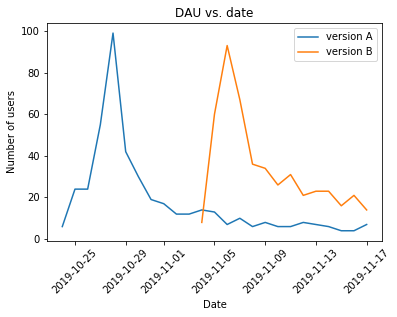

In [9]:
retention_version_A['dt'] = retention_version_A['timestamp'].apply(lambda x: datetime.date(x))
retention_version_B['dt'] = retention_version_B['timestamp'].apply(lambda x: datetime.date(x))


dau_A = retention_version_A.groupby('dt').user_id.nunique().reset_index(name='num_users')
dau_B = retention_version_B.groupby('dt').user_id.nunique().reset_index(name='num_users')

plt.plot(dau_A['dt'], dau_A['num_users'], label='version A')
plt.plot(dau_B['dt'], dau_B['num_users'], label='version B')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.title('DAU vs. date')
plt.xticks(rotation=45)
plt.show()

#### Retention

Day 1 retention rates are similar for the two versions, but then diverge over longer periods. From day 2 onward version B shows higher retention. For example, day 7 retention was 5.6% for version A but 11.4% for version B. 

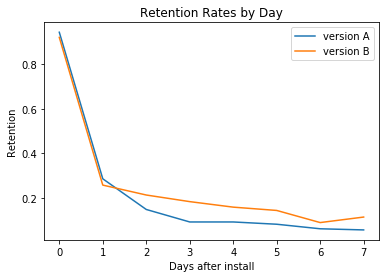

In [10]:
plt.plot(day_retention_A['day_number'][:8], day_retention_A['retention'][:8], label='version A')
plt.plot(day_retention_B['day_number'][:8], day_retention_B['retention'][:8], label='version B')
plt.legend()
plt.xlabel('Days after install')
plt.ylabel('Retention')
plt.title('Retention Rates by Day')
plt.show()

#### Engagement

Overall sessions per user were higher for version B than for version A: roughly 7 sessions per user vs. 6. This is more striking given a shorter timescale of activity has been recorded for B than for A. Sessions per day per user are shown below.  

The spike on day 2 for version B should be investigated. Did we target users to come back in version B, for example with a push notification or a reward? Or was this the result of levels users reach on day 2 being slightly easier? Otherwise the general trend is sessions per user increasing with day number for later days, indicating the most committed players are the ones still left a week after installing. 

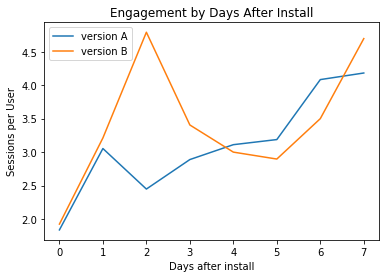

In [11]:
sessions_per_day_A = retention_version_A.groupby('day_number')[['session_id', 'user_id']].nunique().reset_index()
sessions_per_day_B = retention_version_B.groupby('day_number')[['session_id', 'user_id']].nunique().reset_index()
sessions_per_day_A.columns=['day_number', 'sessions', 'users']
sessions_per_day_B.columns=['day_number', 'sessions', 'users']

sessions_per_day_A['sessions_per_user'] = sessions_per_day_A['sessions']/sessions_per_day_A['users']
sessions_per_day_B['sessions_per_user'] = sessions_per_day_B['sessions']/sessions_per_day_B['users']

plt.plot(sessions_per_day_A['day_number'][:8], sessions_per_day_A['sessions_per_user'][:8], label='version A')
plt.plot(sessions_per_day_B['day_number'][:8], sessions_per_day_B['sessions_per_user'][:8], label='version B')
plt.legend()
plt.xlabel('Days after install')
plt.ylabel('Sessions per User')
plt.title('Engagement by Days After Install')
plt.show()

### Funnel

Users in versions A and B dropped off at roughly similar rates by level, though version B users made it slightly farther. Level difficulties seem to be roughly similar between versions. However, version A is a bit harder for levels 18 and 19 which may explain the extra drop off. Level 18 is a big drop-off point for both versions, though, because it's much harder than the levels that came before it. 

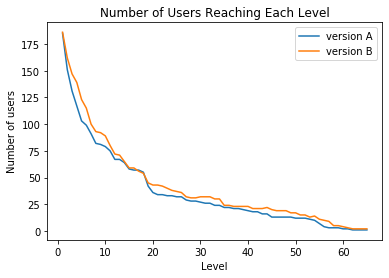

In [12]:
level_starts_A = version_A[version_A.event_name=='LevelStart'].groupby('current_level')['user_id'].nunique().reset_index(name='num_users')
level_starts_B = version_B[version_B.event_name=='LevelStart'].groupby('current_level')['user_id'].nunique().reset_index(name='num_users')

plt.plot(level_starts_A['current_level'], level_starts_A['num_users'], label='version A')
plt.plot(level_starts_B['current_level'], level_starts_B['num_users'], label='version B')
plt.legend()
plt.xlabel('Level')
plt.ylabel('Number of users')
plt.title('Number of Users Reaching Each Level')
plt.show()



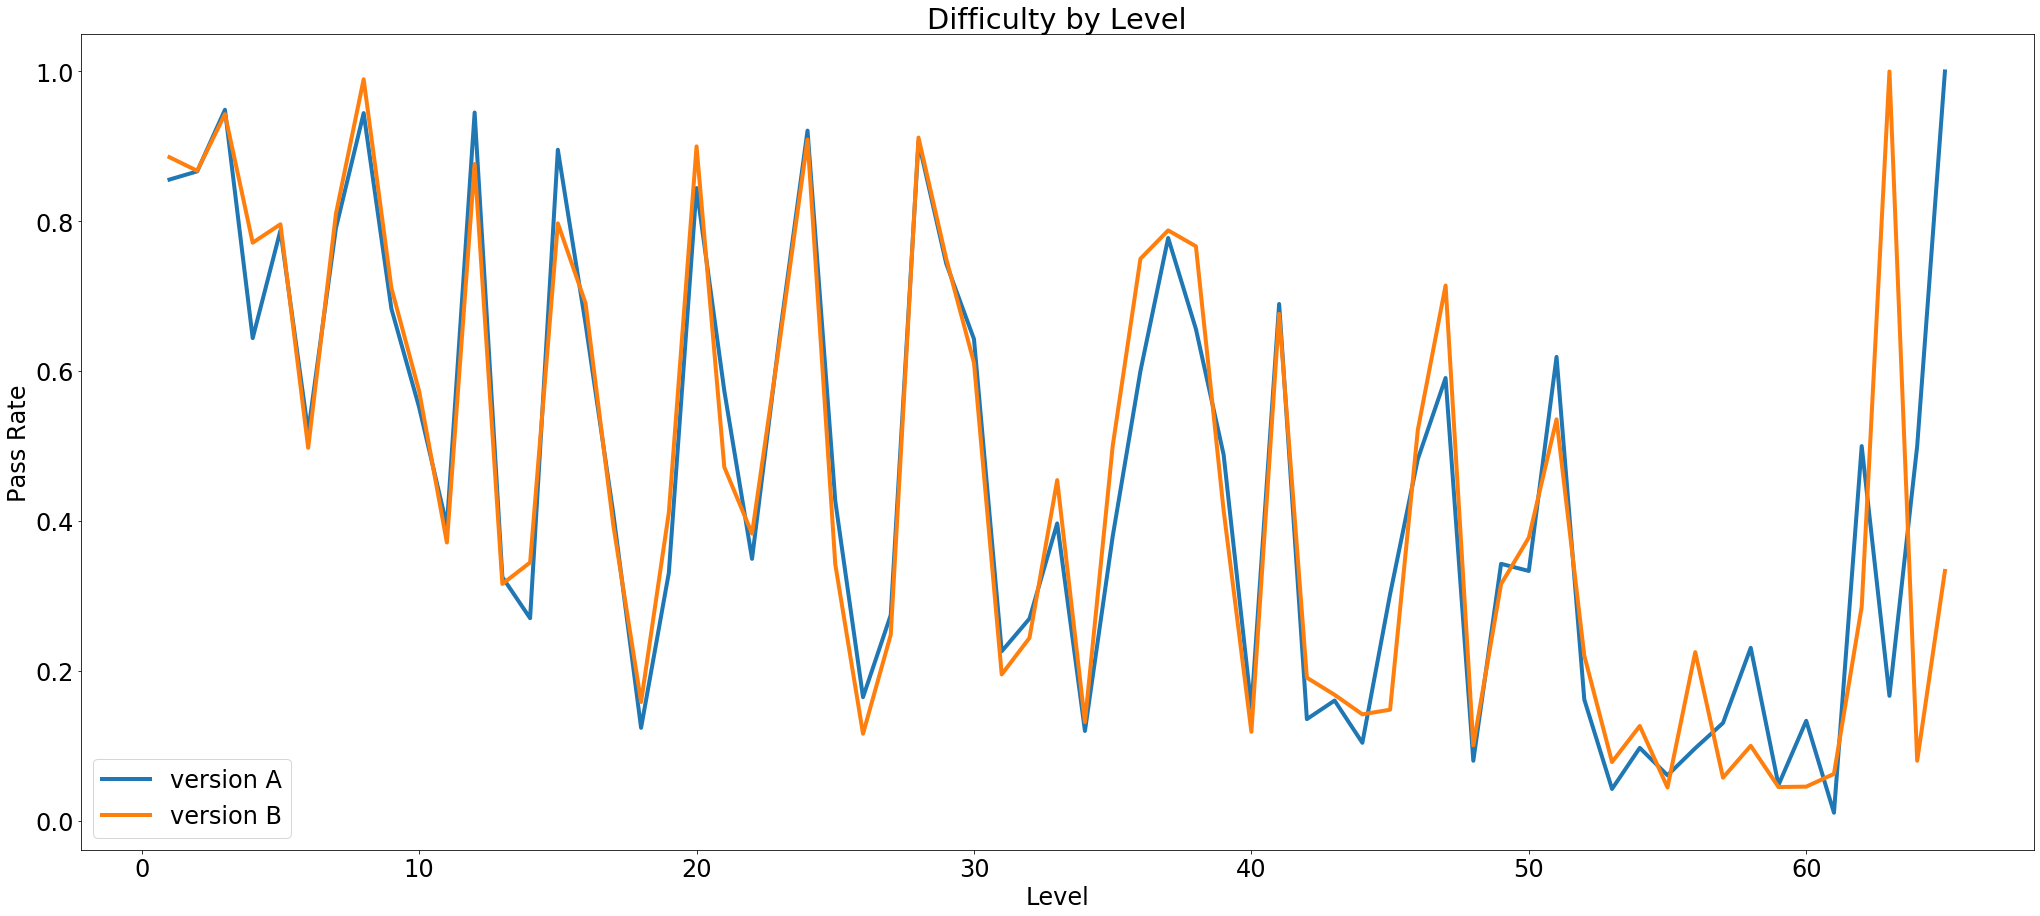

In [17]:
level_starts_A = version_A[version_A.event_name=='LevelStart'].groupby('current_level').size().reset_index(name='starts')
level_starts_B = version_B[version_B.event_name=='LevelStart'].groupby('current_level').size().reset_index(name='starts')

level_passes_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='pass'))].groupby('current_level').size().reset_index(name='passes')
level_fails_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='fail'))].groupby('current_level').size().reset_index(name='fails')
level_exits_A = version_A[((version_A.event_name=='LevelEnd')&(version_A.level_end_outcome=='exit'))].groupby('current_level').size().reset_index(name='exits')

level_passes_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='pass'))].groupby('current_level').size().reset_index(name='passes')
level_fails_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='fail'))].groupby('current_level').size().reset_index(name='fails')
level_exits_B = version_B[((version_B.event_name=='LevelEnd')&(version_B.level_end_outcome=='exit'))].groupby('current_level').size().reset_index(name='exits')


difficulties_A = level_starts_A.merge(level_passes_A, how='left', on='current_level').merge(level_fails_A, how='left', on='current_level').merge(level_exits_A, how='left', on='current_level').fillna(0)
difficulties_B = level_starts_B.merge(level_passes_B, how='left', on='current_level').merge(level_fails_B, how='left', on='current_level').merge(level_exits_B, how='left', on='current_level').fillna(0)

difficulties_A['pass_rate'] = difficulties_A['passes']/difficulties_A['starts']
difficulties_B['pass_rate'] = difficulties_B['passes']/difficulties_B['starts']

plt.plot(difficulties_A['current_level'], difficulties_A['pass_rate'], label='version A')
plt.plot(difficulties_B['current_level'], difficulties_B['pass_rate'], label='version B')
plt.legend()
plt.rcParams["figure.figsize"] = (35,15)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['font.size'] = 24
plt.xlabel('Level')
plt.ylabel('Pass Rate')
plt.title('Difficulty by Level')
plt.show()



### Monetization

There were 17 payers for version A and 14 for version B. This equated to 9.2% and 7.5% of users respectively. The total spend for version A was 150, half of which was due to a single whale spending 70. The total spend for version B was 50. A few more monetization numbers: 


Version A ARPU: 0.81 

Version B ARPU: 0.26


Version A ARPPU: 8.82

Version B ARPPU: 3.57

** ARPU: average revenue per user.  ARPPU: average revenue per paying user

If the whale is removed from the data these numbers appear more similar (0.41 ARPU and 5.0 ARPPU for version A), so some of the spread is likely due to chance. 

In version A, users started spending at slightly earlier levels (11 onward) compared with version B (16 onward). 

### Open Questions

- What was the purpose of the intro, which only appeared for version A? 

- What changes were made to the levels between versions? The pass rates look roughly similar except for the levels I've already mentioned, but I would like to know if anything else changed that influenced retention. 

- Were there any push notifications, rewards, or other methods of bringing users of version B back from the second day after install onward? 



### Next steps

I would recommend following users in variant B for another 11 days so that the time window used to compare the two versions is equivalent. This will allow us to compare monetization rates over equivalent periods and see if there is a difference between the two versions. 

I would also look into tweaking a few levels that cause a higher rate of churn for users. For version B this would include levels 18, 26 and 34. 

#### Further analytics

It's important to know why the difference in retention opens up between versions A and B on the second day of game play. In both groups, players generally got up to around level 18 on the first day of play, but then version B players started progressing much faster. The pass rate for levels 18 and especially 19 are a bit lower for version A.

Ideally I would like to talk to the game designers to understand what differences there are between versions here, beyond just difficulty. For example, differences in mechanics and where boosters are available would be good to know. I would also like to understand the point of the intro, to see if it should be tested further. 

#### Telemetry improvements

We could use some improvements to our tracking to better understand how users play the game: 
- Logging any communication we have with users through notifications. 
- Enhanced purchase events. We currently only know how much players spend on currency and at what level, not what this money is spent on. What types of boosters are they buying? From this we could better tell if we're offering the right selection of boosters and which ones are most useful for which level. 
- An event telling us when users uninstall the game from their phone. This would give a clear indication they are unhappy with the game and have completely stopped playing. 
- Logging the type of mobile device would be useful. Now we don't know if there are any differences between ios and android, and between phone and tablet. This is not necessary yet if the game has only been launched on one platform though. 

#### Reporting requirements

To monitor game metrics it's important to have daily updating dashboards:

- Key metrics: DAU, retention, spend, etc. 
- Drop-off per level, to see where users are churning. 
- Level difficulty, to make sure the players are passing at the rates the game designers expect. 